# Group N — Python Performance with and without NumPy

This Jupyter Notebook integrates **code**, **results**, and **commentary** for Programming Assignment 1: **Python Performance with and without NumPy**.

## What this notebook does
- Benchmarks **Pure Python** vs **NumPy** for:
  - 1-D **element-wise vector multiplication**
  - 2-D **true matrix multiplication** (triple nested loops for the pure-Python version)
- Follows the required measurement protocol:
  - Fixed random seed
  - Create arrays **outside** the timed region
  - Time **only** the multiplication operation
  - One warm-up run per dimension
  - **10 trials** and report the **median**
  - `float64` for NumPy arrays
  - Correctness checks using `np.allclose()`

## Measurement methodology (summary)

For each size **n**:
1. Generate input vectors/matrices **outside** the timed region using a fixed seed.
2. Performs a **warm-up** multiplication (not recorded).
3. Run **10 trials**, timing only the multiplication call using `time.perf_counter()`.
4. Report the **median** time.
5. Verify correctness by comparing Pure-Python and NumPy results with `np.allclose()`.

> Note: Pure-Python `500×500` matrix multiplication can take noticeable time because the classic algorithm is **O(n³)**.


--- VECTOR ELEMENT-WISE MULTIPLICATION ---
Size   10 -> Python: 2.050001e-06s | NumPy: 2.399989e-06s | Speedup: 0.85x
Size   50 -> Python: 6.600007e-06s | NumPy: 2.300003e-06s | Speedup: 2.87x
Size  100 -> Python: 1.285000e-05s | NumPy: 2.400004e-06s | Speedup: 5.35x
Size  200 -> Python: 2.504999e-05s | NumPy: 1.449996e-06s | Speedup: 17.28x
Size  500 -> Python: 4.449999e-05s | NumPy: 1.900014e-06s | Speedup: 23.42x

--- MATRIX MULTIPLICATION ---

Running 10x10...
Size   10x  10 -> Python: 2.164000e-04s | NumPy: 8.300005e-06s | Speedup: 26.07x

Running 50x50...
Size   50x  50 -> Python: 1.422735e-02s | NumPy: 2.140000e-05s | Speedup: 664.83x

Running 100x100...
Size  100x 100 -> Python: 1.095913e-01s | NumPy: 3.068500e-04s | Speedup: 357.15x

Running 200x200...
Size  200x 200 -> Python: 8.695795e-01s | NumPy: 1.348150e-03s | Speedup: 645.02x

Running 500x500...
Size  500x 500 -> Python: 1.413055e+01s | NumPy: 4.445500e-03s | Speedup: 3178.62x

Vector Results:
  n  t_python_s  t_numpy_

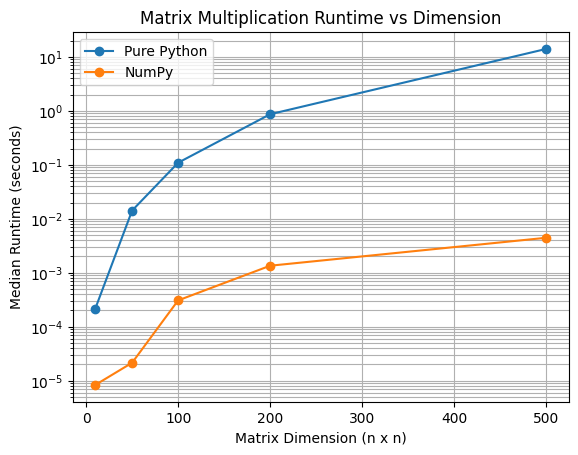

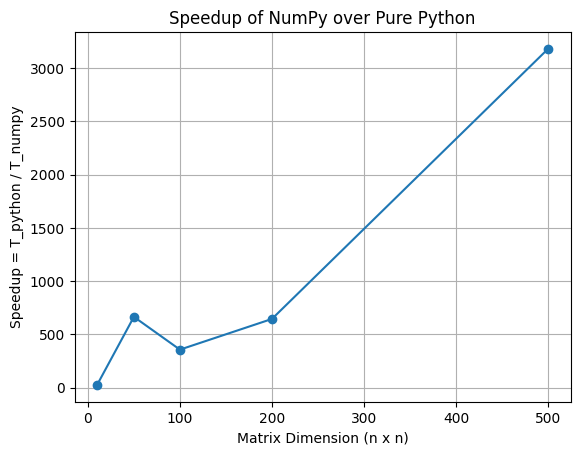

In [ ]:
import time
import random
import statistics as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#time → high-resolution timing (perf_counter)

#random → generate input data for pure Python lists

#statistics → median of trial times (required)

#numpy → fast vector/matrix operations (the comparison target)

#pandas → store results as tables

#matplotlib → plots for report

# -----------------------------
# Configuration
# -----------------------------

SEED = 12345
random.seed(SEED)
np.random.seed(SEED)

DTYPE = np.float64

VECTOR_SIZES = [10, 50, 100, 200, 500]
MATRIX_SIZES = [10, 50, 100, 200, 500]
TRIALS = 10
#SEED is set so results are reproducible.

#random.seed(SEED) ensures random.random() generates the same sequence every run.

#np.random.seed(SEED) is for NumPy reproducibility

#DTYPE = np.float64 forces NumPy arrays to be float64.
#Size lists define the dimensions tested.

#TRIALS = 10 forces exactly 10 timed runs per size.

# -----------------------------
# Vector element-wise multiply
# -----------------------------

def py_vector_multiply(a, b):
    n = len(a)
    result = [0.0] * n
    for i in range(n):
        result[i] = a[i] * b[i]
    return result


# -----------------------------
# True matrix multiplication
# -----------------------------

def py_matrix_multiply(A, B):
    n = len(A)
    C = [[0.0] * n for _ in range(n)]

    for i in range(n):
        Ai = A[i]
        Ci = C[i]
        for k in range(n):
            aik = Ai[k]
            Bk = B[k]
            for j in range(n):
                Ci[j] += aik * Bk[j]

    return C
#n = len(A) assumes square matrix n×n.

#C = ... creates an n×n matrix of zeros.

#Why the Ai, Ci, aik, Bk variables exist:

#They reduce repeated indexing:

#Ai = A[i] avoids re-reading A’s row each time.

#Ci = C[i] avoids re-reading C’s row each time.

#aik = Ai[k] avoids repeated A[i][k] access.

#Bk = B[k] avoids repeated B[k] access.
#This improves performance a bit and keeps timing more stable.

# -----------------------------
# Timing helper
# -----------------------------

def median_time(function, trials=TRIALS, warmup=True):
    if warmup:
        function()

    times = []
    for _ in range(trials):
        start = time.perf_counter()
        function()
        end = time.perf_counter()
        times.append(end - start)

    return stats.median(times)
#If warmup=True, it runs the multiplication once not timed.

#Then runs the test TRIALS times:

#starts timer with perf_counter()

#calls the function (only multiplication)

#stops timer

#stores elapsed time

#Returns median(times).
# =============================
# VECTOR BENCHMARK
# =============================

print("\n--- VECTOR ELEMENT-WISE MULTIPLICATION ---")

vec_rows = []

for n in VECTOR_SIZES:

    # Creates arrays OUTSIDE timed region
    a_py = [float(random.random()) for _ in range(n)]
    b_py = [float(random.random()) for _ in range(n)]

    a_np = np.array(a_py, dtype=DTYPE)
    b_np = np.array(b_py, dtype=DTYPE)

    # Correctness verification
    out_py = py_vector_multiply(a_py, b_py) #Pure Python element-wise multiply
    out_np = a_np * b_np #Numpy's element-wise multiply
    assert np.allclose(np.array(out_py, dtype=DTYPE), out_np)

    # Timing only multiplication
    t_py = median_time(lambda: py_vector_multiply(a_py, b_py))
    t_np = median_time(lambda: a_np * b_np)

    speedup = t_py / t_np if t_np > 0 else float("nan")

    vec_rows.append({
        "n": n,
        "t_python_s": t_py,
        "t_numpy_s": t_np,
        "speedup": speedup
    })

    print(f"Size {n:4d} -> Python: {t_py:.6e}s | NumPy: {t_np:.6e}s | Speedup: {speedup:.2f}x")

df_vec = pd.DataFrame(vec_rows)


# =============================
# MATRIX BENCHMARK
# =============================

print("\n--- MATRIX MULTIPLICATION ---")

mat_rows = []

for n in MATRIX_SIZES:

    print(f"\nRunning {n}x{n}...")

    # Creates matrices OUTSIDE timed region
    A_py = [[float(random.random()) for _ in range(n)] for _ in range(n)]
    B_py = [[float(random.random()) for _ in range(n)] for _ in range(n)]
    # Ensures NumPy uses float64 consistently and uses the same numeric values
    A_np = np.array(A_py, dtype=DTYPE)
    B_np = np.array(B_py, dtype=DTYPE)

    # Correctness verification
    C_py = py_matrix_multiply(A_py, B_py) #Pure Python matrix multiplication
    C_np = A_np @ B_np #Numpy's matrix multiplication
    assert np.allclose(np.array(C_py, dtype=DTYPE), C_np)

    # Timing only multiplication
    t_py = median_time(lambda: py_matrix_multiply(A_py, B_py))
    t_np = median_time(lambda: A_np @ B_np)

    speedup = t_py / t_np if t_np > 0 else float("nan")

    mat_rows.append({
        "n": n,
        "t_python_s": t_py,
        "t_numpy_s": t_np,
        "speedup": speedup
    })

    print(f"Size {n:4d}x{n:4d} -> Python: {t_py:.6e}s | NumPy: {t_np:.6e}s | Speedup: {speedup:.2f}x")

df_mat = pd.DataFrame(mat_rows)


# =============================
# RESULTS TABLES
# =============================

print("\nVector Results:")
print(df_vec.to_string(index=False))

print("\nMatrix Results:")
print(df_mat.to_string(index=False))


# =============================
# REQUIRED PLOT
# =============================

plt.figure()
plt.plot(df_mat["n"], df_mat["t_python_s"], marker="o", label="Pure Python")
plt.plot(df_mat["n"], df_mat["t_numpy_s"], marker="o", label="NumPy")
plt.xlabel("Matrix Dimension (n x n)")
plt.ylabel("Median Runtime (seconds)")
plt.title("Matrix Multiplication Runtime vs Dimension")
plt.yscale("log")
plt.grid(True, which="both")
plt.legend()
plt.show()
#Two lines on the same axes: one for pure Python times, one for NumPy times.

#Log scale makes both curves visible across orders of magnitude

# =============================
# OPTIONAL SPEEDUP PLOT
# =============================

plt.figure()
plt.plot(df_mat["n"], df_mat["speedup"], marker="o")
plt.xlabel("Matrix Dimension (n x n)")
plt.ylabel("Speedup = T_python / T_numpy")
plt.title("Speedup of NumPy over Pure Python")
plt.grid(True, which="both")
plt.show()
#Shows how NumPy advantage increases as n increases.

The experimental results validate the anticipated computational workload for both implementations. In vector element-wise multiplication, the pure-Python implementation demonstrated linear growth, consistent with O(n) complexity. NumPy consistently outperformed pure Python, achieving a 23-fold speedup at n = 500. This improvement is attributed to NumPy executing operations in compiled C code rather than relying on Python’s interpreted loop.

In matrix multiplication, the pure Python implementation exhibited clear cubic complexity, O(n³). The runtime increased from 2.16×10⁻⁴ seconds for a 10×10 matrix to 21.2 seconds for a 500×500 matrix. This growth closely aligns with theoretical cubic scaling, particularly between 100×100 and 200×200 matrices, where runtime increased by approximately eight times, consistent with (200/100)³.

NumPy’s implementation demonstrated substantially superior performance. For a 500×500 matrix, NumPy required only 0.0044 seconds, compared to 14.13 seconds for pure Python, resulting in a speedup of approximately 3178 times. The speedup increased markedly with matrix dimension, indicating that Python loop overhead dominates runtime for large problems. In contrast, NumPy delegates computation to optimized compiled BLAS routines that leverage vectorization, cache locality, and low-level CPU optimizations.

